In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from bioinfokit.analys import stat
import researchpy as rp
import numpy as np
import datetime
import fiona
from shapely.geometry import shape, Point, Polygon, MultiPolygon

In [2]:
def read_data(path):
    return pd.read_csv(path)

In [3]:
file_path = "./datasets/Motor_Vehicle_Collisions_-_Crashes.csv"
data = read_data(file_path)

/home/milica/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### Shape of dataset

In [4]:
data.shape

(1759301, 29)

In [5]:
data['CRASH DATE'] = pd.to_datetime(data['CRASH DATE'])
df = data.loc[(data['CRASH DATE'] >= datetime.datetime(2014, 9, 13)) & (data['CRASH DATE'] <= datetime.datetime(2019, 11, 24))] 

In [6]:
df.shape

(1164268, 29)

In [7]:
df.dtypes

CRASH DATE                       datetime64[ns]
CRASH TIME                               object
BOROUGH                                  object
ZIP CODE                                 object
LATITUDE                                float64
LONGITUDE                               float64
LOCATION                                 object
ON STREET NAME                           object
CROSS STREET NAME                        object
OFF STREET NAME                          object
NUMBER OF PERSONS INJURED               float64
NUMBER OF PERSONS KILLED                float64
NUMBER OF PEDESTRIANS INJURED             int64
NUMBER OF PEDESTRIANS KILLED              int64
NUMBER OF CYCLIST INJURED                 int64
NUMBER OF CYCLIST KILLED                  int64
NUMBER OF MOTORIST INJURED                int64
NUMBER OF MOTORIST KILLED                 int64
CONTRIBUTING FACTOR VEHICLE 1            object
CONTRIBUTING FACTOR VEHICLE 2            object
CONTRIBUTING FACTOR VEHICLE 3           

In [8]:
pd.set_option('display.max_columns', None)
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
1776,2016-04-28,22:51,BROOKLYN,11233.0,NaN,NaN,NaN,HALSEY STREET,LEWIS AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,3433951,4 dr sedan,NaN,NaN,NaN,NaN
1991,2016-05-02,12:25,MANHATTAN,10019.0,NaN,NaN,NaN,WEST 56 STREET,8 AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,Backing Unsafely,NaN,NaN,NaN,NaN,3437300,Sedan,NaN,NaN,NaN,NaN
2018,2016-05-02,17:35,NaN,NaN,NaN,NaN,NaN,BELT PARKWAY,NaN,NaN,2.0,0.0,0,0,0,0,2,0,Driver Inexperience,NaN,NaN,NaN,NaN,3433825,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
2207,2016-04-26,9:40,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY SERVICE RO,LINDEN PLACE,NaN,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,3426806,Pick-up Truck,4 dr sedan,NaN,NaN,NaN
2342,2016-04-26,20:15,BRONX,10459.0,NaN,NaN,NaN,PROSPECT AVENUE,HOME STREET,NaN,1.0,0.0,1,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,3411702,4 dr sedan,NaN,NaN,NaN,NaN


### Columns with null values

In [9]:
def cols_with_null(df):
    sum_nan = df.isnull().sum().to_frame()
    sum_nan.columns=['#NaN']
    sum_nan_thresh = sum_nan[sum_nan['#NaN'] > 0]
    pd.set_option('display.max_rows', None)
    print(sum_nan_thresh)

In [10]:
cols_with_null(df)

                                  #NaN
BOROUGH                         383774
ZIP CODE                        383972
LATITUDE                        126686
LONGITUDE                       126686
LOCATION                        126686
ON STREET NAME                  251407
CROSS STREET NAME               475692
OFF STREET NAME                 953381
NUMBER OF PERSONS INJURED           17
NUMBER OF PERSONS KILLED            31
CONTRIBUTING FACTOR VEHICLE 1     3718
CONTRIBUTING FACTOR VEHICLE 2   163851
CONTRIBUTING FACTOR VEHICLE 3  1089357
CONTRIBUTING FACTOR VEHICLE 4  1148577
CONTRIBUTING FACTOR VEHICLE 5  1160190
VEHICLE TYPE CODE 1               7058
VEHICLE TYPE CODE 2             200827
VEHICLE TYPE CODE 3            1092059
VEHICLE TYPE CODE 4            1149195
VEHICLE TYPE CODE 5            1160344


In [11]:
def rows_nan(df):
    sum_nan_by_row = df.isnull().sum(axis=1).to_frame()
    sum_nan_by_row.columns=['#NaN']
    # sum_nan_thresh = sum_nan[sum_nan['#NaN'] > 0]
    pd.set_option('display.max_rows', 30)
    print(sum_nan_by_row)
    return sum_nan_by_row

In [12]:
# pd.set_option('display.max_rows', 30)
# temp = df[(pd.isna(df["LOCATION"]))]
# np.median(temp["CRASH DATE"])

### Removing missing values

In [13]:
# remove missing location
index_names = df[(pd.isna(df["LOCATION"])) | (pd.isna(df["NUMBER OF PERSONS INJURED"])) | (pd.isna(df["NUMBER OF PERSONS KILLED"])) ].index
df = df.drop(index_names) 

In [14]:
# sum_nan_row_thresh = sum_nan_by_row[sum_nan_by_row['#NaN'] > 16]
# sum_nan_row_thresh.shape
cols_with_null(df)

                                  #NaN
BOROUGH                         285878
ZIP CODE                        286059
ON STREET NAME                  225930
CROSS STREET NAME               430003
OFF STREET NAME                 838497
CONTRIBUTING FACTOR VEHICLE 1     3344
CONTRIBUTING FACTOR VEHICLE 2   148756
CONTRIBUTING FACTOR VEHICLE 3   971272
CONTRIBUTING FACTOR VEHICLE 4  1023573
CONTRIBUTING FACTOR VEHICLE 5  1033880
VEHICLE TYPE CODE 1               6275
VEHICLE TYPE CODE 2             183311
VEHICLE TYPE CODE 3             973688
VEHICLE TYPE CODE 4            1024121
VEHICLE TYPE CODE 5            1034013


In [15]:
df.shape

(1037549, 29)

### Find borough by location

In [16]:
def find_borough(polygons, point):
    for i in range(5):
        if point.within(polygons[i]):
            return i
    return None

#### Read multipolygons from shape file

In [17]:
import shapefile
polys = shapefile.Reader('./datasets/Borough Boundaries/geo_export_621be77d-f760-4b8e-b564-92005e6a1d45.shp')
multi = []
for i in range(5):
    multi.append(shape(polys.shapeRecords()[i].shape.__geo_interface__))
boroughs = ['STATEN ISLAND', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'BRONX']

#### Staten Island

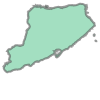

In [18]:
multi[0]

#### Brooklyn

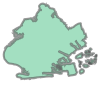

In [19]:
multi[1]

#### Manhattan

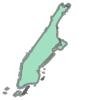

In [20]:
multi[2]

#### Queens

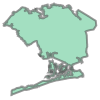

In [21]:
multi[3]

#### Bronx

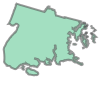

In [22]:
multi[4]

In [23]:
df.shape

(1037549, 29)

In [24]:
df = df[(df['LATITUDE'] < 40.9) & (df['LATITUDE'] > 40.5)]
df = df[(df['LONGITUDE'] < -73.7) & (df['LONGITUDE'] > -74.3)]

In [25]:
df.shape

(1033533, 29)

In [26]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
rp.summary_cat(df["BOROUGH"])

,Variable,Outcome,Count,Percent
0,BOROUGH,BROOKLYN,237178,31.68
1,,QUEENS,205544,27.45
2,,MANHATTAN,170255,22.74
3,,BRONX,106258,14.19
4,,STATEN ISLAND,29430,3.93


In [27]:
outliers = []
index_names = df[(pd.isna(df["BOROUGH"]))].index
index_names = df.index
for i in index_names:
    row = df.loc[[i]]
    point = Point(row['LONGITUDE'], row['LATITUDE'])
    borough_index = find_borough(multi, point)
    if borough_index is not None:
        df.loc[i,'BOROUGH'] = boroughs[borough_index]
    else:
        outliers.append(i)
        df.loc[i,'BOROUGH'] = None
# point = Point(0.5, 0.5)
# polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
# print(polygon.contains(point))
# missing_borough

In [28]:
index_names = df[(pd.isna(df["BOROUGH"]))].index
df = df.drop(index_names) 

In [29]:
len(outliers)

7168

In [30]:
cols_with_null(df)

                                  #NaN
ZIP CODE                        278136
ON STREET NAME                  224405
CROSS STREET NAME               421155
OFF STREET NAME                 828433
CONTRIBUTING FACTOR VEHICLE 1     3327
CONTRIBUTING FACTOR VEHICLE 2   147482
CONTRIBUTING FACTOR VEHICLE 3   961524
CONTRIBUTING FACTOR VEHICLE 4  1012759
CONTRIBUTING FACTOR VEHICLE 5  1022783
VEHICLE TYPE CODE 1               6219
VEHICLE TYPE CODE 2             181654
VEHICLE TYPE CODE 3             963854
VEHICLE TYPE CODE 4            1013276
VEHICLE TYPE CODE 5            1022910


In [31]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
rp.summary_cat(df["BOROUGH"])

,Variable,Outcome,Count,Percent
0,BOROUGH,BROOKLYN,306402,29.85
1,,QUEENS,298244,29.06
2,,MANHATTAN,222903,21.72
3,,BRONX,149756,14.59
4,,STATEN ISLAND,49060,4.78


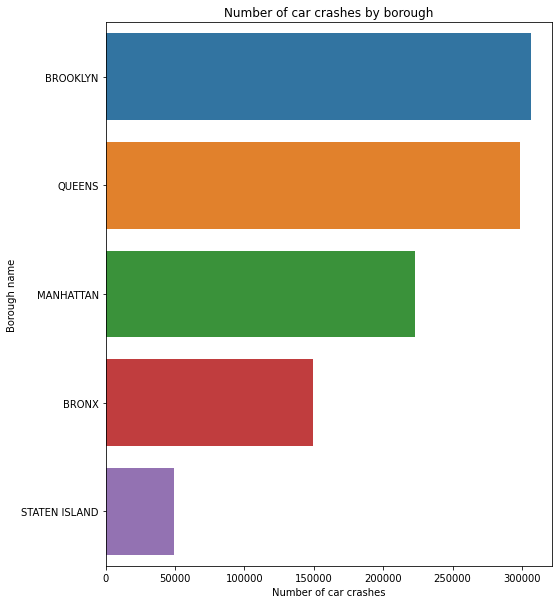

In [32]:
plt.figure(figsize = (8,10))
sns.countplot(y= 'BOROUGH', data = df, order = df['BOROUGH'].value_counts().index)
plt.ylabel('Borough name')
plt.xlabel('Number of car crashes')
plt.title('Number of car crashes by borough')
plt.show()

### Save data

In [33]:
df.to_csv("./processed_data_all_borough.csv", index=False)

In [34]:
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
14933,2019-11-24,20:00,MANHATTAN,10006.0,40.70983,-74.01468,"(40.70983, -74.01468)",WEST STREET,ALBANY STREET,NaN,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Passing Too Closely,NaN,NaN,NaN,4247215,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
14949,2019-11-24,16:11,BROOKLYN,NaN,40.70029,-73.92904,"(40.70029, -73.92904)",CENTRAL AVENUE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,4246795,4 dr sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
14969,2019-11-24,12:20,BROOKLYN,11201.0,40.69119,-73.99780,"(40.69119, -73.9978)",ATLANTIC AVENUE,HICKS STREET,NaN,1.0,0.0,0,0,0,0,1,0,Unsafe Lane Changing,Unspecified,NaN,NaN,NaN,4246353,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
15002,2019-09-26,13:07,BROOKLYN,11204.0,40.63291,-73.97957,"(40.63291, -73.97957)",43 STREET,17 AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,Backing Unsafely,Unspecified,NaN,NaN,NaN,4215020,Sedan,Sedan,NaN,NaN,NaN
15007,2019-11-24,11:51,BRONX,NaN,40.85535,-73.91836,"(40.85535, -73.91836)",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4246365,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN


### Add columns for severity of crash

In [35]:
df['NUMBER OF PERSONS INJURED'] = df['NUMBER OF PERSONS INJURED'].astype(int)
df['NUMBER OF PERSONS KILLED'] = df['NUMBER OF PERSONS KILLED'].astype(int)
df["INJURED"] = df["NUMBER OF PERSONS INJURED"] + df["NUMBER OF PEDESTRIANS INJURED"] + df["NUMBER OF CYCLIST INJURED"] + df["NUMBER OF MOTORIST INJURED"]
df["KILLED"] = df["NUMBER OF PERSONS KILLED"] + df["NUMBER OF PEDESTRIANS KILLED"] + df["NUMBER OF CYCLIST KILLED"] + df["NUMBER OF MOTORIST KILLED"]

In [36]:
columns_to_remove = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED','NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
                    'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED']
df_new = df.drop(columns= columns_to_remove)

In [37]:
columns_to_remove = ['CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 
                    'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
df_new = df_new.drop(columns= columns_to_remove)
df_new.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,INJURED,KILLED
14933,2019-11-24,20:00,MANHATTAN,10006.0,40.70983,-74.01468,"(40.70983, -74.01468)",WEST STREET,ALBANY STREET,NaN,Passing Too Closely,Passing Too Closely,4247215,Sedan,Station Wagon/Sport Utility Vehicle,0,0
14949,2019-11-24,16:11,BROOKLYN,NaN,40.70029,-73.92904,"(40.70029, -73.92904)",CENTRAL AVENUE,NaN,NaN,Failure to Yield Right-of-Way,Unspecified,4246795,4 dr sedan,Station Wagon/Sport Utility Vehicle,0,0
14969,2019-11-24,12:20,BROOKLYN,11201.0,40.69119,-73.99780,"(40.69119, -73.9978)",ATLANTIC AVENUE,HICKS STREET,NaN,Unsafe Lane Changing,Unspecified,4246353,Sedan,Station Wagon/Sport Utility Vehicle,2,0
15002,2019-09-26,13:07,BROOKLYN,11204.0,40.63291,-73.97957,"(40.63291, -73.97957)",43 STREET,17 AVENUE,NaN,Backing Unsafely,Unspecified,4215020,Sedan,Sedan,0,0
15007,2019-11-24,11:51,BRONX,NaN,40.85535,-73.91836,"(40.85535, -73.91836)",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,Unspecified,Unspecified,4246365,Station Wagon/Sport Utility Vehicle,Sedan,0,0


In [38]:
cols_with_null(df_new)

                                 #NaN
ZIP CODE                       278136
ON STREET NAME                 224405
CROSS STREET NAME              421155
OFF STREET NAME                828433
CONTRIBUTING FACTOR VEHICLE 1    3327
CONTRIBUTING FACTOR VEHICLE 2  147482
VEHICLE TYPE CODE 1              6219
VEHICLE TYPE CODE 2            181654


In [39]:
df_new.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,INJURED,KILLED
14933,2019-11-24,20:00,MANHATTAN,10006.0,40.70983,-74.01468,"(40.70983, -74.01468)",WEST STREET,ALBANY STREET,NaN,Passing Too Closely,Passing Too Closely,4247215,Sedan,Station Wagon/Sport Utility Vehicle,0,0
14949,2019-11-24,16:11,BROOKLYN,NaN,40.70029,-73.92904,"(40.70029, -73.92904)",CENTRAL AVENUE,NaN,NaN,Failure to Yield Right-of-Way,Unspecified,4246795,4 dr sedan,Station Wagon/Sport Utility Vehicle,0,0
14969,2019-11-24,12:20,BROOKLYN,11201.0,40.69119,-73.99780,"(40.69119, -73.9978)",ATLANTIC AVENUE,HICKS STREET,NaN,Unsafe Lane Changing,Unspecified,4246353,Sedan,Station Wagon/Sport Utility Vehicle,2,0
15002,2019-09-26,13:07,BROOKLYN,11204.0,40.63291,-73.97957,"(40.63291, -73.97957)",43 STREET,17 AVENUE,NaN,Backing Unsafely,Unspecified,4215020,Sedan,Sedan,0,0
15007,2019-11-24,11:51,BRONX,NaN,40.85535,-73.91836,"(40.85535, -73.91836)",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,Unspecified,Unspecified,4246365,Station Wagon/Sport Utility Vehicle,Sedan,0,0


In [40]:
df_new.to_csv("./processed_all_borough.csv", index=False)

### Number of unique values by column

In [41]:
df_unique = df_new.nunique().to_frame()
df_unique.columns=['#Unique']
df_unique

,#Unique
CRASH DATE,1899
CRASH TIME,1440
BOROUGH,5
ZIP CODE,440
LATITUDE,108147
LONGITUDE,84562
LOCATION,202217
ON STREET NAME,7038
CROSS STREET NAME,12403
OFF STREET NAME,123660


In [42]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
rp.summary_cat(df["BOROUGH"])

,Variable,Outcome,Count,Percent
0,BOROUGH,BROOKLYN,306402,29.85
1,,QUEENS,298244,29.06
2,,MANHATTAN,222903,21.72
3,,BRONX,149756,14.59
4,,STATEN ISLAND,49060,4.78


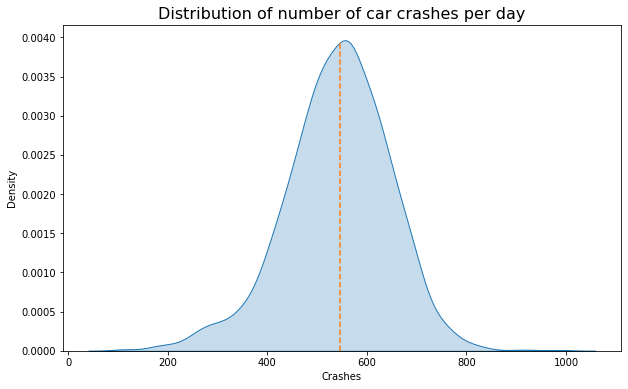

In [43]:
col = sns.color_palette()

plt.figure(figsize=(10, 6))
dates_sumary = rp.summary_cat(df["CRASH DATE"])
count_data = dates_sumary["Count"]
sns.kdeplot(data=count_data, shade=True)
plt.axvline(x=count_data.median(), ymax=0.95, linestyle='--', color=col[1])
plt.title('Distribution of number of car crashes per day', fontdict={'fontsize': 16})
plt.xlabel('Crashes')
plt.show()

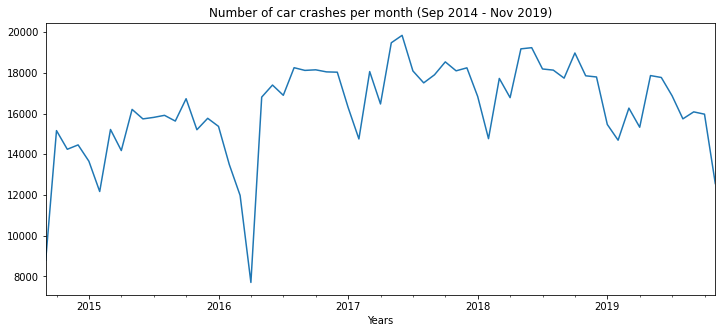

In [44]:
df.index = pd.DatetimeIndex(df["CRASH DATE"])
plt.figure(figsize=(12,5))
df.resample('M').size().plot(legend=False)
plt.title('Number of car crashes per month (Sep 2014 - Nov 2019)')
plt.xlabel('Years')
plt.show()

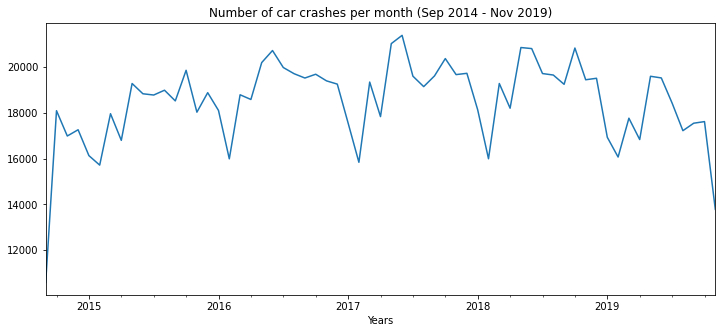

In [45]:
df2 = data.loc[(data['CRASH DATE'] >= datetime.datetime(2014, 9, 13)) & (data['CRASH DATE'] <= datetime.datetime(2019, 11, 24))] 
df2.index = pd.DatetimeIndex(df2["CRASH DATE"])
plt.figure(figsize=(12,5))
df2.resample('M').size().plot(legend=False)
plt.title('Number of car crashes per month (Sep 2014 - Nov 2019)')
plt.xlabel('Years')
plt.show()


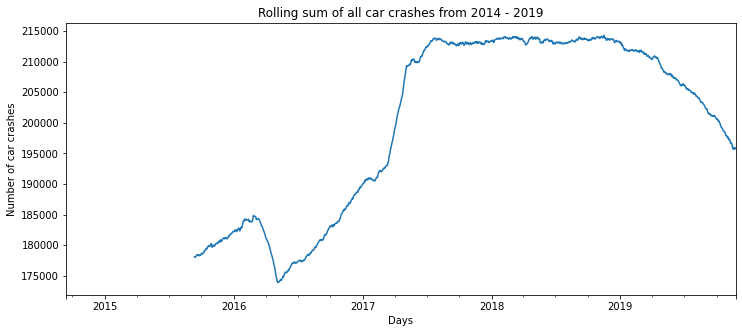

In [46]:
plt.figure(figsize=(12,5))
df.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all car crashes from 2014 - 2019')
plt.ylabel('Number of car crashes')
plt.xlabel('Days')
plt.show()

In [47]:
df['HOUR'] = df['CRASH TIME'].apply(lambda x: x.split(':')[0])
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,INJURED,KILLED,HOUR
CRASH DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-24,2019-11-24,20:00,MANHATTAN,10006.0,40.70983,-74.01468,"(40.70983, -74.01468)",WEST STREET,ALBANY STREET,NaN,0,0,0,0,0,0,0,0,Passing Too Closely,Passing Too Closely,NaN,NaN,NaN,4247215,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,0,0,20
2019-11-24,2019-11-24,16:11,BROOKLYN,NaN,40.70029,-73.92904,"(40.70029, -73.92904)",CENTRAL AVENUE,NaN,NaN,0,0,0,0,0,0,0,0,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,4246795,4 dr sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,0,0,16
2019-11-24,2019-11-24,12:20,BROOKLYN,11201.0,40.69119,-73.99780,"(40.69119, -73.9978)",ATLANTIC AVENUE,HICKS STREET,NaN,1,0,0,0,0,0,1,0,Unsafe Lane Changing,Unspecified,NaN,NaN,NaN,4246353,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2,0,12
2019-09-26,2019-09-26,13:07,BROOKLYN,11204.0,40.63291,-73.97957,"(40.63291, -73.97957)",43 STREET,17 AVENUE,NaN,0,0,0,0,0,0,0,0,Backing Unsafely,Unspecified,NaN,NaN,NaN,4215020,Sedan,Sedan,NaN,NaN,NaN,0,0,13
2019-11-24,2019-11-24,11:51,BRONX,NaN,40.85535,-73.91836,"(40.85535, -73.91836)",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4246365,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,0,0,11


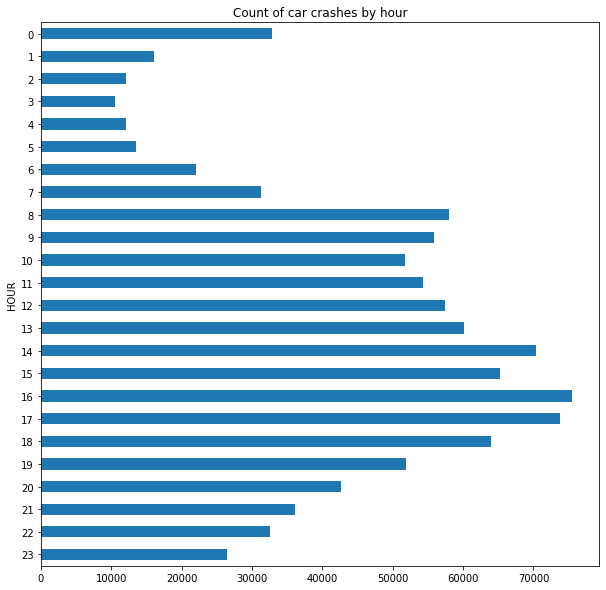

In [48]:
df['HOUR'] = df['HOUR'].astype(int)
df.groupby('HOUR')['COLLISION_ID'].count().plot(kind='barh', figsize=(10,10), title='Count of car crashes by hour').invert_yaxis()

In [49]:
df = df[(df['LATITUDE'] < 40.9) & (df['LATITUDE'] > 40.5)]
d = df[df["INJURED"] > 0]

In [50]:
file_path = "./processed_data.csv"
data = pd.read_csv(file_path)
data.head()

/home/milica/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2019-11-24,20:00,MANHATTAN,10006.0,40.70983,-74.01468,"(40.70983, -74.01468)",WEST STREET,ALBANY STREET,NaN,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Passing Too Closely,NaN,NaN,NaN,4247215,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1,2019-11-24,16:11,BROOKLYN,NaN,40.70029,-73.92904,"(40.70029, -73.92904)",CENTRAL AVENUE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,4246795,4 dr sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
2,2019-11-24,12:20,BROOKLYN,11201.0,40.69119,-73.99780,"(40.69119, -73.9978)",ATLANTIC AVENUE,HICKS STREET,NaN,1.0,0.0,0,0,0,0,1,0,Unsafe Lane Changing,Unspecified,NaN,NaN,NaN,4246353,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
3,2019-09-26,13:07,BROOKLYN,11204.0,40.63291,-73.97957,"(40.63291, -73.97957)",43 STREET,17 AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,Backing Unsafely,Unspecified,NaN,NaN,NaN,4215020,Sedan,Sedan,NaN,NaN,NaN
4,2019-11-24,11:51,BRONX,NaN,40.85535,-73.91836,"(40.85535, -73.91836)",MAJOR DEEGAN EXPRESSWAY,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4246365,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN


In [51]:
index_names = data[(pd.isna(data["ON STREET NAME"]))].index

In [52]:
index_names.shape

(224426,)

In [55]:
temp = index_names[index_names < 2631]

In [56]:
temp.shape

(682,)

In [61]:
temp = index_names[index_names < 15881]

In [62]:
temp.shape

(3991,)